# **Detection with Frame Differencing**

In this notebook we will explore a simple method of moving object detection via Frame Differencing. This detection method could then be extended to object tracking with methods such as template matching or a simple detection based tracker with Hungarian matching.

#### Assumptions
1) Static Camera
2) Objects move smoothly across each frame (i.e. they don't move too quickly)


### Method
1) Take Frame Difference: $d = frame_{t+1} - frame_{t}$
2) Threshold frame difference to get mask
3) Perform Morphological operations to reduce noise and make the moving objects stand out more
4) Perform detection on mask via contour finding
5) Non maximal supression of proposed detections
6) Draw bounding boxes

##### This is a very simple approach to moving object detection. We wont spend much time optimizing this is just to obtain a better fundamental understanding of moving object detection.

In [9]:
from glob import glob
import re
import numpy as np
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

### Extract the frames of the video

In [10]:
vidcap = cv2.VideoCapture('dataset/traffic.mp4')
success,image = vidcap.read()
count = 0
while success:
  cv2.imwrite("dataset/frames/frame%d.jpg" % count, image)
  success,image = vidcap.read()
  print('Read a new frame: ', success)
  count += 1

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

### Visualize the data

We are using highway traffic scene data. The camera does not move and the cars are all moving, both of which make it ideal to obtain the background. 

Helper function to visualize images in sequence

In [11]:
# get properly sorted images
data_path = r'dataset/frames'
image_paths = sorted(glob(f"{data_path}/*.jpg"), key=lambda x:float(re.findall("(\d+)",x)[0]))

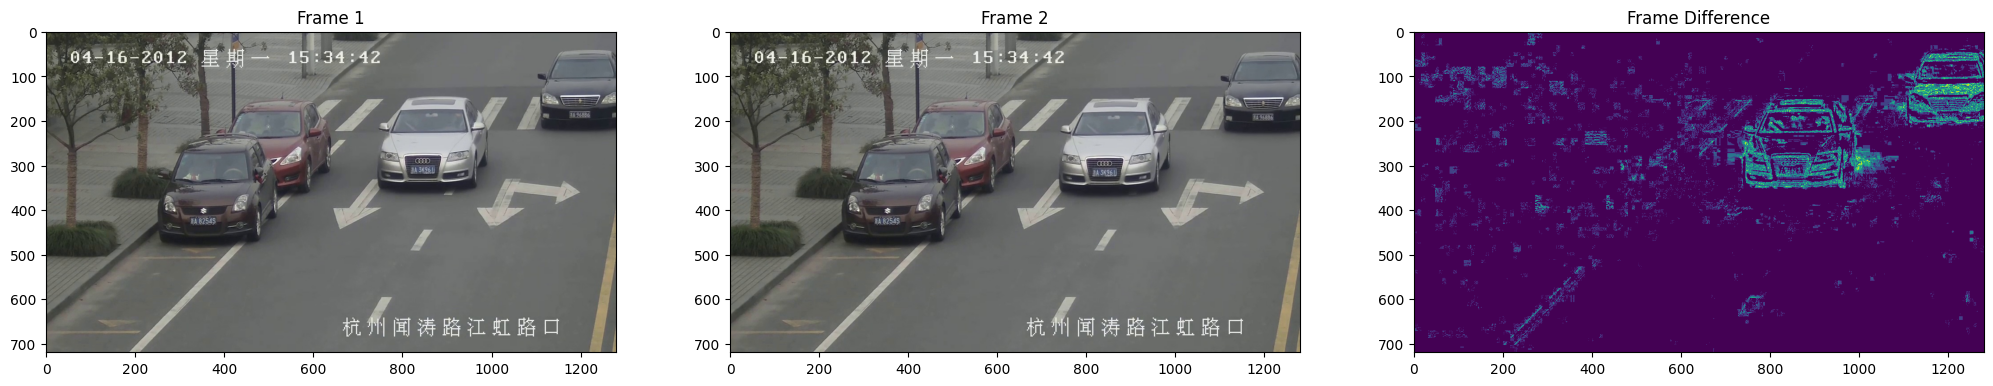

In [12]:
idx = 170

img1_rgb = cv2.cvtColor(cv2.imread(image_paths[idx]), cv2.COLOR_BGR2RGB)
img2_rgb = cv2.cvtColor(cv2.imread(image_paths[idx+1]), cv2.COLOR_BGR2RGB)

# convert to grayscale
img1 = cv2.cvtColor(img1_rgb, cv2.COLOR_RGB2GRAY)
img2 = cv2.cvtColor(img2_rgb, cv2.COLOR_RGB2GRAY)

# compute grayscale image difference
grayscale_diff = cv2.subtract(img2, img1)

fig, ax = plt.subplots(1, 3, figsize=(25, 25))
ax[0].imshow(img1_rgb)
ax[0].set_title('Frame 1')
ax[1].imshow(img2_rgb)
ax[1].set_title('Frame 2')
ax[2].imshow(grayscale_diff*50) # scale the frame difference to show the noise
ax[2].set_title('Frame Difference');

## **Get Motion Mask**
The second step after the frame differencing is to get a thresholded image mask. This image mask will give us relative locations of all moving targets.

In [13]:
def get_mask(frame1, frame2, kernel=np.array((9,9), dtype=np.uint8)):
    """ Obtains image mask
        Inputs: 
            frame1 - Grayscale frame at time t
            frame2 - Grayscale frame at time t + 1
            kernel - (NxN) array for Morphological Operations
        Outputs: 
            mask - Thresholded mask for moving pixels
        """
    frame_diff = cv2.subtract(frame2, frame1)

    # blur the frame difference
    frame_diff = cv2.medianBlur(frame_diff, 3)
    
    mask = cv2.adaptiveThreshold(frame_diff, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
                cv2.THRESH_BINARY_INV, 11, 3)

    mask = cv2.medianBlur(mask, 3)

    # morphological operations
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=1)

    return mask

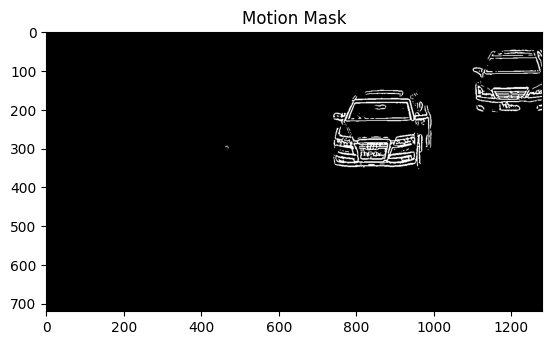

In [14]:
kernel = np.array((9,9), dtype=np.uint8)
mask = get_mask(img1, img2, kernel)

plt.imshow(mask, cmap='gray')
plt.title("Motion Mask");

## **Get Detections from Motion Mask**
Next we will find the contours on our image mask. These contours will help find the large moving objects that we wish to detect.

Then we will use the detected contours to find the moving objects. To do this we will use the "boundingRect" function to obtain bounding box locations of the detections. You may have noticed that the image mask was not perfectly denoised, instead of denoising the image mask we will use the area of each detected bounding box as a threshold to determine the initial detectons. Most object detectors have a score or confidence level that usually ranges from 0-1. In this case, we don't have either, but we will use an augmented score based on the area of each bounding box. The main assumption for this is that the largest contour (and alrgest bounding box) will usually correspond to the real object or cluster of objects.

In [15]:
def get_contour_detections(mask, thresh=400):
    """ Obtains initial proposed detections from contours discoverd on the mask. 
        Scores are taken as the bbox area, larger is higher.
        Inputs:
            mask - thresholded image mask
            thresh - threshold for contour size
        Outputs:
            detectons - array of proposed detection bounding boxes and scores [[x1,y1,x2,y2,s]]
        """
    # get mask contours
    contours, _ = cv2.findContours(mask, 
                                   cv2.RETR_EXTERNAL, # cv2.RETR_TREE, 
                                   cv2.CHAIN_APPROX_TC89_L1)
    detections = []
    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)
        area = w*h
        if area > thresh: # hyperparameter
            detections.append([x,y,x+w,y+h, area])
            
    return np.array(detections)

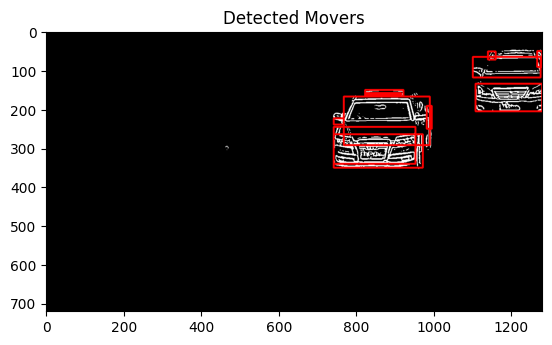

In [16]:
mask_rgb = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
detections = get_contour_detections(mask, thresh=400)

# separate bboxes and scores
bboxes = detections[:, :4]
scores = detections[:, -1]

for box in bboxes:
    x1,y1,x2,y2 = box
    cv2.rectangle(mask_rgb, (x1,y1), (x2,y2), (255,0,0), 3)

plt.imshow(mask_rgb)
plt.title("Detected Movers");

## **Perform Non-Maximal Supression**
Next we need to perform non-maximal supression. First we will need a method of computing the Intersection over Union (IOU). We will write functions for this and display the interesected areas on our RGB mask. Before we get started, we will annotate all the overalapping boxes on the motion mask

In [17]:
def compute_iou(box1, box2):
    """ Obtains Intersection over union (IOU) of 2 bounding boxes
        Inputs are in the form of:
            xmin, ymin, xmax, ymax = box
        """
    x11, y11, x21, y21 = box1
    x12, y12, x22, y22 = box2

    # get box points of intersection
    xi1 = max(x11, x12) # top left
    yi1 = max(y11, y12)
    xi2 = min(x21, x22) # bottom right
    yi2 = min(y21, y22)

    # compute intersectional area
    inter_area = max((xi2 - xi1 + 1), 0) * max((yi2 - yi1 + 1), 0)
    if inter_area == 0:
        return inter_area

    # compute box areas
    box1_area = (x21 - x11 + 1) * (y21 - y11 + 1)
    box2_area = (x22 - x12 + 1) * (y22 - y12 + 1)

    # return iou
    return inter_area / (box1_area + box2_area - inter_area)


def get_inter_area(box1, box2):
    """
    Obtains bounding box for intersection area of two boundning boxes
    Inputs are in the form of:
            xmin, ymin, xmax, ymax = box
    """
    x11, y11, x21, y21 = box1
    x12, y12, x22, y22 = box2

    # get box points of intersection
    xi1 = max(x11, x12) # top left
    yi1 = max(y11, y12)
    xi2 = min(x21, x22) # bottom right
    yi2 = min(y21, y22)

    # compute intersectional area
    inter_area = max((xi2 - xi1 + 1), 0) * max((yi2 - yi1 + 1), 0)
    if inter_area == 0:
        return 0, 0, 0, 0
        
    return xi1, yi1, xi2, yi2

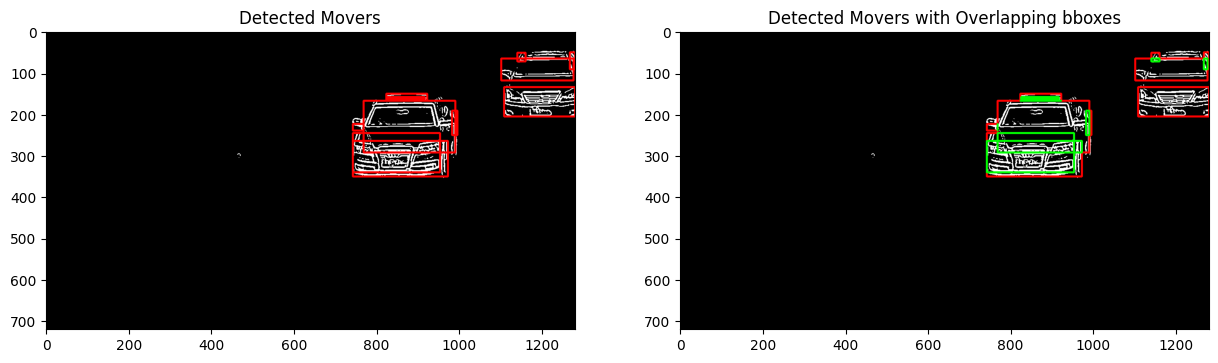

In [18]:
mask_rgb_iou = mask_rgb.copy()

# only compare unique cases
idx_1, idx_2 = np.triu_indices(len(bboxes), k=1)

for i in range(len(idx_1)):
    b1 = bboxes[idx_1[i]].tolist()
    b2 = bboxes[idx_2[i]].tolist()
    iou = compute_iou(b1, b2)
    if iou > 0:
        # print(idx, np.round(iou,2))

        # draw intersection
        x1, y1, x2, y2 = get_inter_area(b1, b2)
        cv2.rectangle(mask_rgb_iou, (x1,y1), (x2,y2), (0,255,0), 3)

fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].imshow(mask_rgb)
ax[0].set_title('Detected Movers')
ax[1].imshow(mask_rgb_iou)
ax[1].set_title('Detected Movers with Overlapping bboxes');

## **Perform Non-Maximal Suppression**
We will take a specialized approach to non-maximal suppression (nms). Typically nms removes bounding boxes with some overlap that exceeds a predefined threshold. In this case we want to tailor nms to our use case of contour detection. As seen in the image above, their are many smaller boxes contained within the larger boxes, we want to remove all of these smaller boxes.

We will use the following algorithm to implement non-maximal supression:
- Sort detected boxes by score in descending order and store them in array
- Remove boxes that are entirely contained within another box
- Start with the largest box
- Compare it with all other boxes
- If IOU exceeds the threshold, remove it
- Repeat for next largest remaining box

In [19]:
def remove_contained_bboxes(boxes):
    """ Removes all smaller boxes that are contained within larger boxes.
        Requires bboxes to be soirted by area (score)
        Inputs:
            boxes - array bounding boxes sorted (descending) by area 
                    [[x1,y1,x2,y2]]
        Outputs:
            keep - indexes of bounding boxes that are not entirely contained 
                   in another box
        """
    check_array = np.array([True, True, False, False])
    keep = list(range(0, len(boxes)))
    for i in keep: # range(0, len(bboxes)):
        for j in range(0, len(boxes)):
            # check if box j is completely contained in box i
            if np.all((np.array(boxes[j]) >= np.array(boxes[i])) == check_array):
                try:
                    keep.remove(j)
                except ValueError:
                    continue
    return keep


def non_max_suppression(boxes, scores, threshold=1e-1):
    """
    Perform non-max suppression on a set of bounding boxes and corresponding scores.
    Inputs:
        boxes: a list of bounding boxes in the format [xmin, ymin, xmax, ymax]
        scores: a list of corresponding scores 
        threshold: the IoU (intersection-over-union) threshold for merging bounding boxes
    Outputs:
        boxes - non-max suppressed boxes
    """
    # Sort the boxes by score in descending order
    boxes = boxes[np.argsort(scores)[::-1]]

    # remove all contained bounding boxes and get ordered index
    order = remove_contained_bboxes(boxes)

    keep = []
    while order:
        i = order.pop(0)
        keep.append(i)
        for j in order:
            # Calculate the IoU between the two boxes
            intersection = max(0, min(boxes[i][2], boxes[j][2]) - max(boxes[i][0], boxes[j][0])) * \
                           max(0, min(boxes[i][3], boxes[j][3]) - max(boxes[i][1], boxes[j][1]))
            union = (boxes[i][2] - boxes[i][0]) * (boxes[i][3] - boxes[i][1]) + \
                    (boxes[j][2] - boxes[j][0]) * (boxes[j][3] - boxes[j][1]) - intersection
            iou = intersection / union

            # Remove boxes with IoU greater than the threshold
            if iou > threshold:
                order.remove(j)
                
    return boxes[keep]

In [20]:
nms_bboxes = non_max_suppression(bboxes, scores, threshold=0.1)
len(bboxes), len(nms_bboxes)

(11, 9)

Now we will draw our final detections on the image

In [21]:
mask_rgb_detections = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
for det in nms_bboxes:
    x1, y1, x2, y2 = det
    cv2.rectangle(mask_rgb_detections, (x1,y1), (x2,y2), (255,0,0), 3)

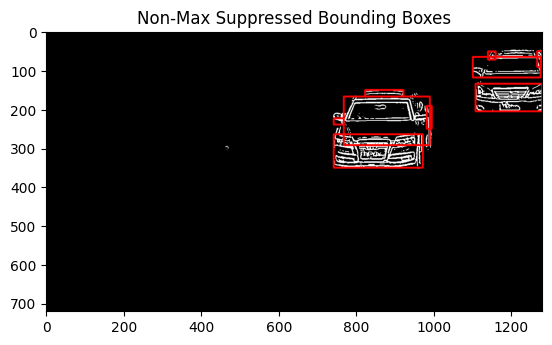

In [22]:
plt.imshow(mask_rgb_detections)
plt.title("Non-Max Suppressed Bounding Boxes");